In [1]:
# imports

# general
import os
import sys
import numpy as np
import string
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# statistics
import scipy
from scipy import stats
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from greatbrowser import great_analysis

# functions
sys.path.append('functions')
from death_prediction_functions import time_to_death_grouped, cross_validation, train_nn, generate_nn_pred
from gene_analysis_functions import get_cistrome, get_pos

# visual modifiers
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
'''
Format healthspan data for neural network
'''

os.chdir('C:\\Users\\Q004\Desktop\\pellegrini_lab_research\\raw_data')
data = pd.read_excel('healthspan_aging_data.xlsx')
data = data.dropna()

# create 'death clock' column
data['death_wks'] = data['death_mo'].apply(lambda x: x*4.3) # convert months to weeks
data['age'] = data['time_point_in_study_weeks'].apply(lambda x: x+12) # add 12 weeks to indicate age at study initiation
data['death_clock'] = data['death_wks'] - data['age'] # subtract what age they die from their current age

data = data.drop(columns=['animal', 'DAI', 'no_recorded_intervals', 'cohort', 'partner', 'age', 'death_wks', 'death_mo'])

# removes negative, only one observed in entire dataset anyways though
data = data[data.death_clock >= 0]

# make strain numeric
data['strain'] = data['strain'].replace('CD1', '0,1')
data['strain'] = data['strain'].replace('C57BL6', '1,1')
data['strain'] = data['strain'].replace('Sv129', '1,0')

# split into dummy encoded categories
data[['C57BL6J or Sv129Ev', 'CD1 or C57BL6J']] = data['strain'].str.split(',', expand=True)
data[['C57BL6J or Sv129Ev', 'CD1 or C57BL6J']]

# make these categories integer for computation
data['C57BL6J or Sv129Ev'] =  data['C57BL6J or Sv129Ev'].astype(int)
data['CD1 or C57BL6J'] = data['CD1 or C57BL6J'].astype(int)
data = data.drop(columns=['strain'])

# make rank numeric
data['rank'] = data['rank'].replace('sub', 0)
data['rank'] = data['rank'].replace('u_d', 1)
data['rank'] = data['rank'].replace('dom', 2)

X = data.drop('death_clock', axis=1)
y = data['death_clock']

X

,rank,aggression_index,FI_kcal,BW_g,FM_g,FFM_g,GLU_mg/dL,time_point_in_study_weeks,C57BL6J or Sv129Ev,CD1 or C57BL6J
0,2,1.070400,18.480,45.0,10.22,32.76,163.0,0,0,1
1,2,1.070400,14.630,41.7,6.49,33.60,137.0,4,0,1
2,2,1.070400,20.790,63.8,21.47,40.08,150.0,12,0,1
3,2,1.070400,10.780,68.2,23.70,41.23,234.0,20,0,1
4,2,1.070400,19.635,68.7,23.31,42.91,330.0,28,0,1
...,...,...,...,...,...,...,...,...,...,...
3395,1,0.564513,13.090,38.6,8.52,28.75,157.0,52,1,1
3396,1,0.564513,11.935,48.7,15.96,30.10,138.0,60,1,1
3397,1,0.564513,15.400,46.7,13.97,29.76,145.0,76,1,1
3398,1,0.564513,10.395,49.5,16.21,31.92,169.0,92,1,1


In [3]:
'''
Normalize the data
'''

# capitalize rank
X = X.rename(columns={'rank': 'Rank'})
X_norm = X.drop(columns=['C57BL6J or Sv129Ev', 'CD1 or C57BL6J', 'Rank']) # drop categorical since we don't want to normalize these
X_norm = (X_norm-X_norm.mean())/X_norm.std() # Z-score = (Observed - Expected) / Standard Deviation

# reinstatiate categorical variables
X_norm['C57BL6J or Sv129Ev'] = X['C57BL6J or Sv129Ev']
X_norm['CD1 or C57BL6J'] = X['CD1 or C57BL6J']
X_norm['Rank'] = X['Rank']
X_norm['time_point_in_study_weeks'] = data['time_point_in_study_weeks']

X = X_norm # since X being the input name is common practice
X

,aggression_index,FI_kcal,BW_g,FM_g,FFM_g,GLU_mg/dL,time_point_in_study_weeks,C57BL6J or Sv129Ev,CD1 or C57BL6J,Rank
0,1.351113,1.373038,0.371140,0.104061,0.552334,0.571698,0,0,1,2
1,1.351113,0.281597,0.037376,-0.591097,0.698752,-0.328636,4,0,1,2
2,1.351113,2.027903,2.272587,2.200717,1.828263,0.121531,12,0,1,2
3,1.351113,-0.809845,2.717607,2.616321,2.028716,3.030301,20,0,1,2
4,1.351113,1.700470,2.768177,2.543637,2.321552,6.354610,28,0,1,2
...,...,...,...,...,...,...,...,...,...,...
3395,0.689187,-0.154980,-0.276161,-0.212767,-0.146639,0.363928,52,1,1,1
3396,0.689187,-0.482413,0.745361,1.173822,0.088676,-0.294008,60,1,1,1
3397,0.689187,0.499885,0.543080,0.802946,0.029412,-0.051610,76,1,1,1
3398,0.689187,-0.918989,0.826274,1.220414,0.405915,0.779467,92,1,1,1


In [4]:
'''
Determine differences in model accuracy depending on which trait is scrambled

Step 1: train the model
Step 2: shuffle target trait and observe loss
'''

batch_size = 32
n_iterations = 5  # for cross-validation, 80% train 20% test

scramble_loss = cross_validation(X, y, batch_size, n_iterations, scramble_trait=True)
scramble_loss

IntProgress(value=0, description='Training', max=5)


Number of epochs: 85

Epoch: 0, Loss: 41.317195892333984
Epoch: 50, Loss: 4.189019203186035

Number of epochs: 86

Epoch: 0, Loss: 38.33219909667969
Epoch: 50, Loss: 1.1413164138793945

Number of epochs: 85

Epoch: 0, Loss: 37.260765075683594
Epoch: 50, Loss: 3.507800817489624

Number of epochs: 86

Epoch: 0, Loss: 57.11653518676758
Epoch: 50, Loss: 3.752153158187866

Number of epochs: 85

Epoch: 0, Loss: 34.04037857055664
Epoch: 50, Loss: 12.431711196899414


{'aggression_index_with_time': 15.993550206074673,
 'FI_kcal_with_time': 15.737372508372529,
 'BW_g_with_time': 15.88006623304699,
 'FM_g_with_time': 16.385375794829873,
 'FFM_g_with_time': 17.580853314526312,
 'GLU_mg/dL_with_time': 15.706347896215838,
 'time_point_in_study_weeks_with_time': 35.50696710457141,
 'Strain_with_time': 27.809142899864895,
 'Rank_with_time': 18.1559978139084,
 'aggression_index_no_time': 35.57653790364223,
 'FI_kcal_no_time': 35.25080489324609,
 'BW_g_no_time': 35.11152506465405,
 'FM_g_no_time': 36.498376321933264,
 'FFM_g_no_time': 35.90865421463958,
 'GLU_mg/dL_no_time': 35.3887490882986,
 'Strain_no_time': 31.374516678700406,
 'Rank_no_time': 31.829240182297067}

In [5]:
'''
Determine differences in model accuracy depending on which trait is removed

Step 1: remove target trait then train the model
Step 2: observe loss
'''

batch_size = 32
n_iterations = 5

rm_loss = cross_validation(X, y, batch_size, n_iterations, remove_trait=True)
rm_loss

IntProgress(value=0, description='Training', max=5)

aggression_index_with_time iteration 0 Loss: 16.01871325371024
FI_kcal_with_time iteration 0 Loss: 15.826831485731486
BW_g_with_time iteration 0 Loss: 15.715938034561763
FM_g_with_time iteration 0 Loss: 15.9272156882041
FFM_g_with_time iteration 0 Loss: 16.051733490303924
GLU_mg/dL_with_time iteration 0 Loss: 15.955107060122945
time_point_in_study_weeks_with_time iteration 0 Loss: 19.55096684328435
Strain_with_time iteration 0 Loss: 16.291629155476887
Rank_with_time iteration 0 Loss: 15.904243577069298
aggression_index_no_time iteration 0 Loss: 19.32079059822094
FI_kcal_no_time iteration 0 Loss: 19.648999746325433
BW_g_no_time iteration 0 Loss: 19.647345497394625
FM_g_no_time iteration 0 Loss: 19.476711187068588
FFM_g_no_time iteration 0 Loss: 19.513882840082335
GLU_mg/dL_no_time iteration 0 Loss: 22.15275807877819
Strain_no_time iteration 0 Loss: 20.563419177493685
Rank_no_time iteration 0 Loss: 19.58235708767447
aggression_index_with_time iteration 1 Loss: 14.58729917222673
FI_kcal_w

{'aggression_index_with_time': 15.48201438628115,
 'FI_kcal_with_time': 15.603085098435393,
 'BW_g_with_time': 15.595302414683115,
 'FM_g_with_time': 15.554459061805478,
 'FFM_g_with_time': 15.554993464039491,
 'GLU_mg/dL_with_time': 15.744313508149094,
 'time_point_in_study_weeks_with_time': 19.04869009935047,
 'Strain_with_time': 15.949586238692293,
 'Rank_with_time': 15.493401677066949,
 'aggression_index_no_time': 18.98763058741184,
 'FI_kcal_no_time': 19.37647221883138,
 'BW_g_no_time': 19.3336044446557,
 'FM_g_no_time': 19.14158637460354,
 'FFM_g_no_time': 19.124809809490642,
 'GLU_mg/dL_no_time': 20.77169678780885,
 'Strain_no_time': 19.854254016763694,
 'Rank_no_time': 18.982271263451704}

In [6]:
'''
Format strain-trait value correctly
'''

def format_df_plot(trait_loss_avg):

    # put the avg loss per trait into df format
    sum_data = pd.DataFrame()
    sum_data['trait_avg_loss'] = trait_loss_avg.values()
    sum_data['trait_name'] = trait_loss_avg.keys()
    sum_data.loc[(sum_data['trait_name'] == 'CD1 or C57BL6J'), 'trait_name'] = 'strain' # change name to strain since we removed both at once

    #################

    # get the p value for each trait to determine significance

    n_datapoints = X.shape[0] // n_iterations + 1  # number of loss values per trait
    trait_Z = {}  # dict to store Z-scores

    for key in trait_loss_avg.keys():
        non_trait_loss = []
        for key2 in trait_loss_avg.keys():
            if key2 != key:  # exclude the current trait being tested
                non_trait_loss.append(trait_loss_avg[key2])
            else:
                # calculate standard error and mean for the trait
                trait_sigma = np.std(trait_loss_avg[key]) / np.sqrt(n_datapoints)  
                trait_mean = np.mean(trait_loss_avg[key])  # mean for the trait

        # convert non_trait_loss to a numpy array
        non_trait_loss = np.array(non_trait_loss)
        non_trait_sigma = np.std(non_trait_loss) / np.sqrt(len(non_trait_loss))  # Standard error
        non_trait_mean = np.mean(non_trait_loss)

        # calculate Z-score
        Z = (trait_mean - non_trait_mean) / np.sqrt(trait_sigma**2 + non_trait_sigma**2)
        trait_Z[key] = Z  # Store Z-score

    # calculate p-values and add them to the DataFrame
    p_values = []
    for trait in sum_data['trait_name']:
        p_val = scipy.stats.norm.sf(abs(trait_Z[trait])) * 2  # Two-tailed p-value
        p_values.append(p_val)

    sum_data['trait_corr_p_val'] = p_values  # Add p-values to DataFrame

    #################

    # distinguish subplots
    w_time = sum_data[sum_data.apply(lambda r: r.str.contains('with_time', case=False).any(), axis=1)]
    wout_time = sum_data[sum_data.apply(lambda r: r.str.contains('no_time', case=False).any(), axis=1)] 

    # get rid of un-needed parts of trait names
    w_time['trait_name'] = w_time['trait_name'].map(lambda x: x[:-10]) 
    wout_time['trait_name'] = wout_time['trait_name'].map(lambda x: x[:-8]) 

    w_time_vals = list(w_time['trait_avg_loss'].values)
    w_category = ['with time']*len(w_time_vals) 
    w_names = list(w_time['trait_name'].values)

    wout_time_vals = list(wout_time['trait_avg_loss'].values)
    wout_category = ['without time']*len(wout_time_vals)
    wout_names = list(wout_time['trait_name'].values)

    both_time = pd.DataFrame()
    both_time['loss_values'] = wout_time_vals + w_time_vals
    both_time['trait'] = wout_names + w_names
    both_time['category'] = wout_category + w_category
    both_time = both_time.replace('time_point_in_study_weeks', 'time_point')

    return both_time

In [7]:
'''
Cross Validation w/ all traits
'''

batch_size = 32
n_iterations = 5 #for cross val

sum_approx, sum_actual, sum_losses = cross_validation(X, y, batch_size, n_iterations)

print(sum_losses)
print(np.mean(sum_losses))

IntProgress(value=0, description='Training', max=5)


Number of epochs: 85

Epoch: 0, Loss: 41.317195892333984
Epoch: 50, Loss: 4.189019203186035

Number of epochs: 86

Epoch: 0, Loss: 38.33219909667969
Epoch: 50, Loss: 1.1413164138793945

Number of epochs: 85

Epoch: 0, Loss: 37.260765075683594
Epoch: 50, Loss: 3.507800817489624

Number of epochs: 86

Epoch: 0, Loss: 57.11653518676758
Epoch: 50, Loss: 3.752153158187866

Number of epochs: 85

Epoch: 0, Loss: 34.04037857055664
Epoch: 50, Loss: 12.431711196899414
[3.546783447265625, 4.3332672119140625, 7.0858154296875, 4.649024963378906, 14.02066421508789, 14.175968170166016, 12.411537170410156, 11.432380676269531, 9.534614562988281, 2.2038803100585938, 12.70727252960205, 55.64620590209961, 51.768760681152344, 41.5504264831543, 59.0802116394043, 51.57624435424805, 55.55080795288086, 45.37689208984375, 29.930870056152344, 13.875455856323242, 1.867441177368164, 11.052543640136719, 15.192420959472656, 9.658042907714844, 16.474002838134766, 7.847747802734375, 6.432518005371094, 12.639717102050

In [8]:

'''
Display cross validation results as a graph using the data from all of the iterations combined
'''

val_predictions = pd.DataFrame()
val_predictions['actual'] = [value.item() for value in sum_actual]
val_predictions['approximation'] = [value.item() for value in sum_approx]

print(val_predictions)

avg_loss = sum(sum_losses) / len(sum_losses)
print(f'average validation loss: {avg_loss}')
corr = stats.kendalltau(x=val_predictions['actual'], y=val_predictions['approximation'])

          actual  approximation
0     104.243332     100.696548
1     100.243332     104.576599
2      92.243332      85.157516
3      84.243332      79.594307
4      76.243332      62.222668
...          ...            ...
3385   85.220001      82.767479
3386   77.220001      73.981232
3387   69.220001      63.538303
3388   61.220001      55.704762
3389   53.220001      45.093029

[3390 rows x 2 columns]
average validation loss: 15.641530229349051


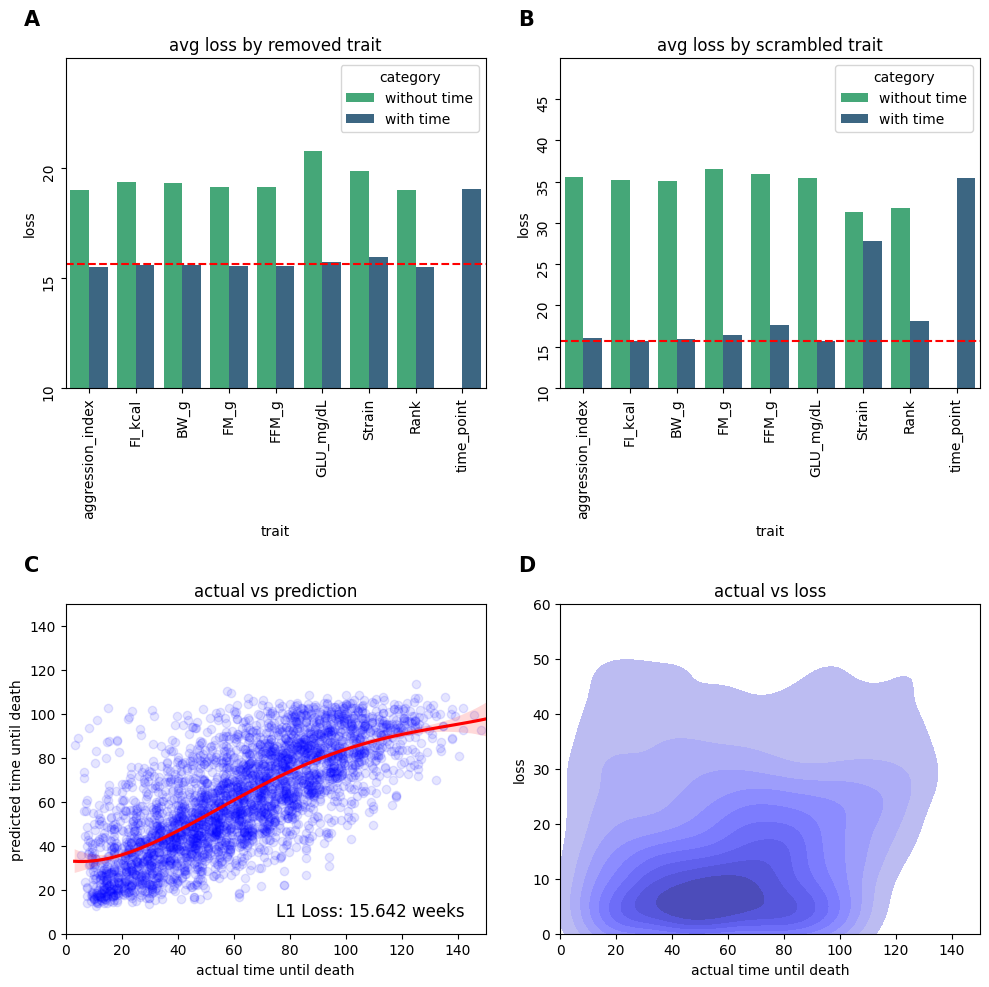

In [9]:
'''
Create plots showing model accuracy
'''

# get formatted Loss
loss_clipped = '{0:.3f}'.format(avg_loss)
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
len_traits = [i for i in range(1,9)]

removal_df = format_df_plot(rm_loss)
scramble_df = format_df_plot(scramble_loss)

# 1 - model accuracy by trait removed
sns.barplot(data = removal_df, x = 'trait', y = 'loss_values', hue = 'category', palette='viridis_r', ax=axs[0,0])
axs[0,0].axhline(float(loss_clipped), color='red', linestyle='--')
axs[0,0].tick_params(labelrotation=90)
axs[0,0].set_ylabel('loss')
axs[0,0].set_ylim([10, 25])
axs[0,0].set_yticks([x for x in range(10, 25, 5)])
axs[0,0].set_title('avg loss by removed trait', size=12)

# 2 - model accuracy by trait scrambled
sns.barplot(data = scramble_df, x = 'trait', y = 'loss_values', hue = 'category', palette='viridis_r', ax=axs[0,1])
axs[0,1].axhline(float(loss_clipped), color='red', linestyle='--')
axs[0,1].tick_params(labelrotation=90)
axs[0,1].set_ylabel('loss')
axs[0,1].set_ylim([10, 50])
axs[0,1].set_yticks([x for x in range(10, 50, 5)])
axs[0,1].set_title('avg loss by scrambled trait', size=12)


# 3 - regplot for prediction vs actual
sns.regplot(data=None, x=val_predictions['actual'], y=val_predictions['approximation'], 
                color='red', order=4, ax=axs[1,0], scatter_kws={'alpha':0.1, 'color':'blue'})

sum_actual = [float(x) for x in sum_actual]
sum_approx = [float(x) for x in sum_approx]

x_max = 150

# these need to be the same to avoid unintentionally manipulating the data
axs[1,0].set_xlim([0,x_max])
axs[1,0].set_ylim([0,x_max])

axs[1,0].set_title('actual vs prediction', size=12)
axs[1,0].set_xlabel('actual time until death')
axs[1,0].set_ylabel('predicted time until death')
axs[1,0].text(s=f'L1 Loss: {loss_clipped} weeks', x=(x_max//2), y=8, size=12)
               
# 4 - regplot for accuracy vs time to death
accuracy_over_time = [np.mean(i) for i in zip(sum_actual,sum_approx)]

sns.kdeplot(data=None, x=val_predictions['actual'], y=sum_losses, 
                color='blue', order=2, ax=axs[1,1], fill=True)

axs[1,1].set_xlim([0,150])
axs[1,1].set_ylim([0,60])

axs[1,1].set_title('actual vs loss')
axs[1,1].set_xlabel('actual time until death')
axs[1,1].set_ylabel('loss')

axs = axs.flat

for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=15, weight='bold')

plt.tight_layout()

In [10]:
'''
Train the whole model
'''
# train the model without a validation set

batch_size = 32
model = train_nn(X, y, batch_size)


Number of epochs: 106

Epoch: 0, Loss: 49.1474494934082
Epoch: 50, Loss: 11.749063491821289
Epoch: 100, Loss: 11.394207954406738


In [11]:
# import the methylation-phenotype cohort
data_2 = pd.read_excel('methylation_phenotype_encoded.xlsx', index_col=0)
data_2 = data_2.dropna()
sep = 55

trait_data = data_2.iloc[:sep]

In [12]:
'''
Import, format, and normalize the phenotype-methylation cohort

Make it so that each timepoint is a unique row
'''

# make a list of lists for each group type
timepoints = ['w12_baseline', 'w16_stress', 'M6_poststress', 
              'M8_poststress', 'M10_poststress', 'M12_poststress', 
              'M14_poststress', 'M16_poststress']
traits = ['food_g', 'BW', 'FM_g', 'FFM_g', 'GLU']

# iterate through all trait/timepoint combinations, create keys for each trait and adding each timepoint as list values
groups = {}
for time in timepoints:
    for trait in traits:
        if trait not in groups: groups[trait] = []
        groups[trait].extend(trait_data.loc[f'{time}_{trait}'])

# add in non-time-varient, non-encoded traits 
groups['aggression_index'] = list(trait_data.loc['Aggression index'])*len(timepoints)

# grams to kcals
groups['FI_kcal'] = [x * 7.716179 for x in groups['food_g']]
groups.pop('food_g')

# rename blood glucose
groups['GLU_mg/dL'] = groups['GLU']
groups.pop('GLU')

# make a df and normalize the values 
time_var_df = pd.DataFrame(groups)
time_var_df_norm = (time_var_df-time_var_df.mean())/time_var_df.std() # z score, pd does this column-wise automatically

# add the params we don't want normalized (i.e. the encoded parameters and time until death)
time_var_df_norm['C57BL6J or Sv129Ev'] = list(trait_data.loc['C57BL6J or Sv129Ev?'])*8
time_var_df_norm['CD1 or C57BL6J'] = list(trait_data.loc['CD1 or C57BL6J?'])*8
time_var_df_norm['Rank'] = list(trait_data.loc['Rank'])*8

# add the timepoint information
# replace each timepoint with same format as train dataset, in weeks, with 0 representing the start of the study
t_numeric = [0, 4, 8.6, 17.2, 25.8, 34.4, 43, 52]
numeric_repeated = [t_numeric for t_numeric in t_numeric for _ in range(trait_data.shape[1])] # number of timepoints * number of animals
working_data = time_var_df_norm.copy()
working_data['time_point_in_study_weeks'] = numeric_repeated

# 
working_data = working_data.reindex(columns=['aggression_index', 'FI_kcal','BW','FM_g','FFM_g','GLU_mg/dL','time_point_in_study_weeks','C57BL6J or Sv129Ev','CD1 or C57BL6J','Rank'])
#

# apply the model to this data
predictions = generate_nn_pred(model, working_data)
working_data['Predicted time until death'] = predictions

working_data.to_excel('death_classifier_pred.xlsx')
working_data

,aggression_index,FI_kcal,BW,FM_g,FFM_g,GLU_mg/dL,time_point_in_study_weeks,C57BL6J or Sv129Ev,CD1 or C57BL6J,Rank,Predicted time until death
0,1.373209,-0.855960,0.102087,-0.611921,0.839169,-0.831634,0.0,0.0,1.0,2.0,82.981949
1,1.387117,-1.353383,-0.355454,-1.229810,0.546992,0.562225,0.0,0.0,1.0,2.0,78.893311
2,1.484477,0.263242,0.231392,-0.226671,0.546992,-1.117554,0.0,0.0,1.0,2.0,87.597359
3,0.389752,0.138887,0.102087,-0.604477,0.640967,-0.009615,0.0,0.0,1.0,1.0,91.487320
4,0.065933,-0.980316,-0.106790,-0.889227,0.704187,-0.009615,0.0,0.0,1.0,2.0,90.176666
...,...,...,...,...,...,...,...,...,...,...,...
363,1.414934,-1.602095,0.480056,0.692718,-0.517490,-0.152575,52.0,1.0,1.0,1.0,52.262756
364,-0.336494,-0.358537,-0.176416,0.476829,-0.197975,0.133345,52.0,1.0,1.0,1.0,53.353806
365,1.192521,0.263242,0.032461,1.358996,0.297531,0.133345,52.0,1.0,1.0,2.0,50.311481
366,-0.665823,-0.482893,0.032461,0.769023,-0.309036,1.348505,52.0,1.0,1.0,0.0,48.193565


In [13]:
'''
Create a parallel model without timepoint, and apply this same data to it
'''

batch_size = 32
model_no_time = train_nn(X.drop(columns=['time_point_in_study_weeks']), y, batch_size)
predictions_no_time = generate_nn_pred(model_no_time, working_data.drop(columns=['time_point_in_study_weeks', 'Predicted time until death']))


Number of epochs: 106

Epoch: 0, Loss: 36.79948043823242
Epoch: 50, Loss: 16.782100677490234
Epoch: 100, Loss: 15.757758140563965


In [14]:
'''
Format dataframes using both model's predictions
'''

# define group_data
str_repeated = [timepoint for timepoint in timepoints for _ in range(trait_data.shape[1])] # number of timepoints * number of animals
group_data = time_var_df_norm.copy()
group_data['group'] = str_repeated
group_data['Predicted time until death'] = predictions

# copy the working and group data
group_data_no_time = group_data.copy()
working_data_no_time = working_data.copy()

# drop timepoint information since it wasnt used in training
working_data_no_time = working_data_no_time.drop(columns=['time_point_in_study_weeks'])

# overwrite the predictions
working_data_no_time['Predicted time until death'] = predictions_no_time
group_data_no_time['Predicted time until death'] = predictions_no_time

working_data_no_time.to_excel('death_classifier_pred_no_time.xlsx')
working_data_no_time

,aggression_index,FI_kcal,BW,FM_g,FFM_g,GLU_mg/dL,C57BL6J or Sv129Ev,CD1 or C57BL6J,Rank,Predicted time until death
0,1.373209,-0.855960,0.102087,-0.611921,0.839169,-0.831634,0.0,1.0,2.0,54.551640
1,1.387117,-1.353383,-0.355454,-1.229810,0.546992,0.562225,0.0,1.0,2.0,75.311165
2,1.484477,0.263242,0.231392,-0.226671,0.546992,-1.117554,0.0,1.0,2.0,67.528580
3,0.389752,0.138887,0.102087,-0.604477,0.640967,-0.009615,0.0,1.0,1.0,82.947739
4,0.065933,-0.980316,-0.106790,-0.889227,0.704187,-0.009615,0.0,1.0,2.0,71.980507
...,...,...,...,...,...,...,...,...,...,...
363,1.414934,-1.602095,0.480056,0.692718,-0.517490,-0.152575,1.0,1.0,1.0,39.283974
364,-0.336494,-0.358537,-0.176416,0.476829,-0.197975,0.133345,1.0,1.0,1.0,64.600746
365,1.192521,0.263242,0.032461,1.358996,0.297531,0.133345,1.0,1.0,2.0,54.247917
366,-0.665823,-0.482893,0.032461,0.769023,-0.309036,1.348505,1.0,1.0,0.0,60.374371


In [15]:
'''
Get the average predictions by group (requires cell above to be run)
'''

groups = ['w12', 'w16']
for i in range(6, 17, 2):
  groups.append('M' + str(i))

# all info
group_data = time_to_death_grouped(group_data, 'group')

# get the average predictions by group when deprived of timepoint information
group_data_no_time = time_to_death_grouped(group_data_no_time, 'group')

Average time to death estimate by group:

            group  Predicted time until death
6    w12_baseline                   90.492134
7      w16_stress                   86.269157
4   M6_poststress                   82.314949
5   M8_poststress                   72.405090
0  M10_poststress                   63.401493
1  M12_poststress                   53.451122
2  M14_poststress                   47.608124
3  M16_poststress                   39.815254


Average time to death estimate by group:

            group  Predicted time until death
6    w12_baseline                   82.800095
7      w16_stress                   79.414337
4   M6_poststress                   71.715042
5   M8_poststress                   61.963947
0  M10_poststress                   56.296288
1  M12_poststress                   53.322132
2  M14_poststress                   49.151520
3  M16_poststress                   44.532745




In [16]:
'''
prep working_data for plotting
'''

working_data['strain'] = working_data['CD1 or C57BL6J'] + working_data['C57BL6J or Sv129Ev']*2
working_data['strain'] = working_data['strain'].replace(1, 'CD1')
working_data['strain'] = working_data['strain'].replace(2, 'Sv129Ev')
working_data['strain'] = working_data['strain'].replace(3, 'C57BL6J')

working_data['Rank'] = working_data['Rank'].replace(0, 'sub')
working_data['Rank'] = working_data['Rank'].replace(1, 'u_d')
working_data['Rank'] = working_data['Rank'].replace(2, 'dom')


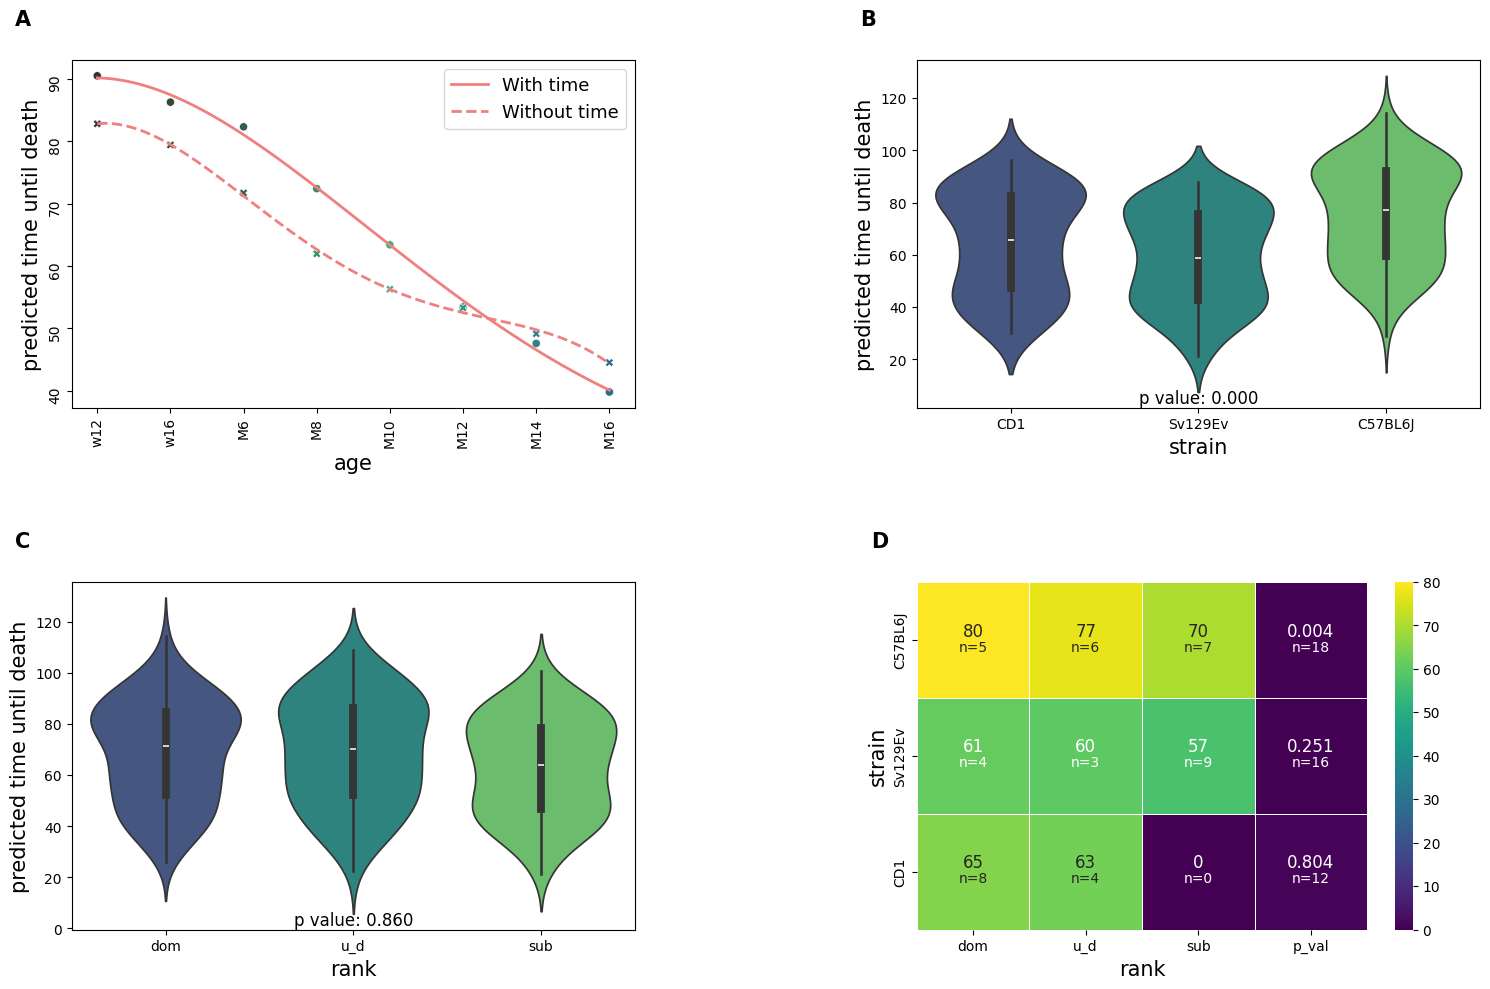

In [17]:
'''
Plot significance of different categories in affecting time to death
'''

##

fig, axs = plt.subplots(2,2, figsize=(15,10))

########### plot 1

# make each group a value on the x axis
group_indices = [x for x in range(0, 8)]

# create a line showing the change in values between groups (with timepoint)
sns.regplot(data=None, x=group_indices, y=group_data['Predicted time until death'], ax=axs[0,0],
            scatter=False, line_kws={'color': 'lightcoral', 'lw':2}, order=4, ci=None)

# make a scatterplot showing the values for each group (with timepoint)
sns.scatterplot(data = None, x = groups, y = group_data['Predicted time until death'], ax=axs[0,0], 
                hue=group_data['Predicted time until death'], palette='viridis_d', legend=False)


# create a line showing the change in values between groups (without timepoint)
sns.regplot(data=None, x=group_indices, y=group_data_no_time['Predicted time until death'], ax=axs[0,0],
            scatter=False, line_kws={'color': 'lightcoral', 'lw':2, 'linestyle':'--'}, order=4, ci=None)

# make a scatterplot showing the values for each group (without timepoint)
sns.scatterplot(data = None, x = groups, y = group_data_no_time['Predicted time until death'], ax=axs[0,0], 
                hue=group_data['Predicted time until death'], palette='viridis_d', legend=False, marker='X')

# create a legend indicating the line useage
solid_line = mlines.Line2D([], [], color='lightcoral', linewidth=2, label='With time')
dashed_line = mlines.Line2D([], [], color='lightcoral', linewidth=2, linestyle='--', label='Without time')

# Add legend to the plot
axs[0,0].legend(handles=[solid_line, dashed_line], loc='best', fontsize=13)

# adjust params
axs[0,0].tick_params(labelrotation=90)
axs[0,0].set_xlabel('age', size=15)
axs[0,0].set_ylabel('predicted time until death', size=15)

########### plot 2

# make a violin plot for each strain type
sns.violinplot(data=None, x=working_data['strain'], y=working_data['Predicted time until death'], 
            ax=axs[0,1], palette='viridis') #note: hue breaks alignment

# get significance of differences acros categories and add to plot
strain_corr = stats.kendalltau(x=working_data['strain'], y=working_data['Predicted time until death'])
strain_corr = '{0:.3f}'.format(strain_corr[1])
axs[0,1].set_title(f'p value: {strain_corr}', y=-0.01, size=12)

# adjust params
axs[0,1].set_xlabel('strain', size=15)
axs[0,1].set_ylabel('predicted time until death', size=15)

########### plot 3

# make a violin plot for each dominance type
sns.violinplot(data=None, x=working_data['Rank'], y=working_data['Predicted time until death'], 
            ax=axs[1,0], palette='viridis')

# determine significance of strain and rank respectively, and add these to their respective plots
rank_corr = stats.kendalltau(x=working_data['Rank'], y=working_data['Predicted time until death'])
rank_corr = '{0:.3f}'.format(rank_corr[1])
axs[1,0].set_title(f'p value: {rank_corr}', y=-0.01, size=12)


# adjust params
axs[1,0].set_xlabel('rank', size=15)
axs[1,0].set_ylabel('predicted time until death', size=15)

########################

# plot 4 computations


temp = working_data.copy()

heatmap_data = temp[['strain', 'Rank', 'Predicted time until death']]
heatmap_data = heatmap_data.pivot_table(values='Predicted time until death', index='strain', 
                      columns='Rank', fill_value=0)


heatmap_data = heatmap_data[['dom', 'u_d', 'sub']]
heatmap_data = heatmap_data.reindex(['C57BL6J', 'Sv129Ev', 'CD1'])
#       C57, Sv, CD1
# dom
# u_d
# sub


##
# determine significance of each heatmap subunit
##

temp['strain'] = temp['strain'].replace('CD1', 1)
temp['strain'] = temp['strain'].replace('Sv129Ev', 2)
temp['strain'] = temp['strain'].replace('C57BL6J', 3)

temp['Rank'] = temp['Rank'].replace('sub', 0)
temp['Rank'] = temp['Rank'].replace('u_d', 1)
temp['Rank'] = temp['Rank'].replace('dom', 2)

# 1 = CD1
# 2 = Sv129
# 3 = C57

# get significance of rank for each strain

C57 = temp.loc[temp['strain'] == 3]
C57 = C57.drop(columns=['strain'])

C57_rank_corr = stats.kendalltau(x=C57['Rank'], y=C57['Predicted time until death'])
C57_rank_corr = '{0:.3f}'.format(C57_rank_corr[1])

#

Sv129 = temp.loc[temp['strain'] == 2]
Sv129 = Sv129.drop(columns=['strain'])

Sv129_rank_corr = stats.kendalltau(x=Sv129['Rank'], y=Sv129['Predicted time until death'])
Sv129_rank_corr = '{0:.3f}'.format(Sv129_rank_corr[1])

#

CD1 = temp.loc[temp['strain'] == 1]
CD1 = CD1.drop(columns=['strain'])

CD1_rank_corr = stats.kendalltau(x=CD1['Rank'], y=CD1['Predicted time until death'])
CD1_rank_corr = '{0:.3f}'.format(CD1_rank_corr[1])

##

C57_n_dom = int(C57[C57['Rank'] == 2].shape[0]/8)
C57_n_neither = int(C57[C57['Rank'] == 1].shape[0]/8)
C57_n_sub = int(C57[C57['Rank'] == 0].shape[0]/8)

C57_sum = C57_n_dom + C57_n_neither + C57_n_sub

#

Sv129_n_dom = int(Sv129[Sv129['Rank'] == 2].shape[0]/8)
Sv129_n_neither = int(Sv129[Sv129['Rank'] == 1].shape[0]/8)
Sv129_n_sub = int(Sv129[Sv129['Rank'] == 0].shape[0]/8)

Sv129_sum = Sv129_n_dom + Sv129_n_neither + Sv129_n_sub

#

CD1_n_dom = int(CD1[CD1['Rank'] == 2].shape[0]/8)
CD1_n_neither = int(CD1[CD1['Rank'] == 1].shape[0]/8)
CD1_n_sub = 0

CD1_sum = CD1_n_dom + CD1_n_neither + CD1_n_sub

##

n_animals = [[f'n={C57_n_dom}', f'n={C57_n_neither}', f'n={C57_n_sub}', f'n={C57_sum}'],
             [f'n={Sv129_n_dom}', f'n={Sv129_n_neither}', f'n={Sv129_n_sub}', f'n={Sv129_sum}'],
             [f'n={CD1_n_dom}', f'n={CD1_n_neither}', 'n=0', f'n={CD1_sum}']]

# C57, Sv, CD1

pvals_rank_strain = [C57_rank_corr, Sv129_rank_corr, CD1_rank_corr]
heatmap_data['p_val'] = pvals_rank_strain
heatmap_data = heatmap_data.astype(float)

heatmap_pretty = heatmap_data

heatmap_pretty['dom'] = heatmap_pretty['dom'].astype(int)
heatmap_pretty['u_d'] = heatmap_pretty['u_d'].astype(int)
heatmap_pretty['sub'] = heatmap_pretty['sub'].astype(int)

heatmap_pretty = heatmap_pretty.astype(str)
heatmap_pretty = heatmap_pretty.values

# plot 4a

# number of animals
sns.heatmap(data=heatmap_data, annot=n_animals, 
            annot_kws={'va':'top', 'fontsize': 10}, 
            fmt='', cbar=False, ax=axs[1,1])

#plot 4b

# avg time to death
sns.heatmap(data=heatmap_data, annot=heatmap_pretty, 
            annot_kws={'va':'bottom', 'fontsize': 12}, 
            fmt='', cbar=False, ax=axs[1,1])

#plot 4c

# formatting
sns.heatmap(data=heatmap_data, annot=False, linewidth=.5, 
            cmap='viridis', ax=axs[1,1])

axs[1,1].set_xlabel('rank', size=15)
axs[1,1].set_ylabel('strain', size=15)


# overall figure stuff

plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels

axs = axs.flat

for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=15, weight='bold')

plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.5)

In [18]:
'''
Calculate a weighted average for each animal using the outputted time until death predictions
'''

n = 0
weights = [2, 5, 8, 11, 14, 17, 20, 23] # since later weights are closer in timepoint to methylation
y = []

while n < trait_data.shape[1]:
  m = 0
  weight_avg = []
  while m < len(weights): 
    weight_avg.append(predictions[(trait_data.shape[1]*m)+n][0]) # since its a list of lists [[info]]
    m+=1
  y.append(np.average(weight_avg, weights=weights))
  n+=1

In [19]:
'''
Decrease number of probes using elastic net model + verify elastic net model's accuracy
'''

meth_data = data_2[sep:]

# restructure the dataset
X = meth_data.T

# get the optimal hyperparameters
"""
OPTIMAL HYPERPARAMETRS: l1=0.1, alpha=0.1

# identify hyperparameters to optimize, and train these
param_grid = {'alpha' : np.arange(0, 1, 0.1), 'l1_ratio' : np.arange(0, 1, 0.01)}
elastic_optimized = GridSearchCV(ElasticNet(), param_grid, cv=6, scoring='neg_mean_squared_error')

# check ideal hyperparameters
print(elastic_optimized.best_estimator_)

"""

# initialize the ElasticNet model with optimal hyperparameters
elastic_optimized = ElasticNet(alpha=0.1, l1_ratio=0.1)

# apply 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=808)

# perform 5-fold cross validation and get the MAE for each fold
cv_mae = cross_val_score(elastic_optimized, X, y, cv=kf, scoring='neg_mean_absolute_error') # random state is arbitrary
cv_mae = -cv_mae # cross_val_score tries to maximize the score
print(f'mean absolute error: {np.mean(cv_mae)}')

# retrain model on all inputs
elastic_optimized.fit(X, y)

# select probes maintained by the model, and add them to the appropriate format
output = meth_data.copy()
#output['coef'] = elastic_optimized.best_estimator_.coef_
output['coef'] = elastic_optimized.coef_
output = output[output.coef != 0] # get rid of 0 values
output

mean absolute error: 5.411714994728628


,627,629,630,633,636,637,640,641,643,646,...,736,741,742_1,744,753,754,757,758,764,coef
ID,,,,,,,,,,,,,,,,,,,,,
cg06905417_TC11,0.648283,0.735703,0.621741,0.681610,0.690306,0.668670,0.731032,0.630405,0.706115,0.701303,...,0.623797,0.757955,0.699784,0.681688,0.741318,0.670748,0.646807,0.702426,0.686071,0.028619
cg07040792_BC11,0.738242,0.633311,0.608819,0.408482,0.701870,0.688076,0.689875,0.755284,0.654415,0.627357,...,0.655193,0.699067,0.608482,0.683419,0.667519,0.692822,0.632297,0.673419,0.677029,0.016964
cg14040602_TC11,0.721542,0.723554,0.774475,0.694922,0.696790,0.720548,0.657998,0.733693,0.718522,0.742394,...,0.773364,0.688450,0.676286,0.724063,0.771638,0.713020,0.722513,0.742873,0.711536,-0.058178
cg23671739_TC21,0.320928,0.279549,0.273689,0.304919,0.332700,0.283284,0.255485,0.273155,0.318968,0.287857,...,0.207184,0.503826,0.196257,0.206083,0.240061,0.278092,0.285879,0.288534,0.246744,-0.090171
cg28112667_TC21,0.650675,0.682499,0.661078,0.662996,0.632708,0.670445,0.668465,0.633594,0.636081,0.649321,...,0.654865,0.527931,0.613502,0.585085,0.611016,0.604262,0.601016,0.642271,0.618297,-0.010687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg48343860_TC21,0.384463,0.702253,0.652929,0.571051,0.407764,0.431368,0.614266,0.389081,0.390043,0.773181,...,0.832396,0.782556,0.817121,0.775774,0.805914,0.809674,0.824136,0.767394,0.792394,0.016668
cg48343900_TC21,0.605775,0.688669,0.628135,0.477835,0.664903,0.623626,0.490616,0.566624,0.521820,0.649207,...,0.586637,0.530213,0.642138,0.617829,0.581122,0.607195,0.636051,0.606737,0.699431,0.157714
cg48343995_TC11,0.274822,0.428012,0.223358,0.292540,0.387572,0.274029,0.286765,0.337042,0.288558,0.378957,...,0.247720,0.240893,0.373390,0.404855,0.390709,0.280386,0.269536,0.394281,0.402555,0.195779


In [20]:
# add chromosome positions and associated genes to dataframe

%reload_ext autoreload
working_data = output.copy()

ref_data = pd.read_excel('mm39_formatted_manifest.xlsx', index_col=0)
probe_df = get_pos(working_data, ref_data)

temp = probe_df.reset_index()
probe_df = great_analysis(temp, get='genes', df_chr ='chr_mm10', df_start='pos_mm10', df_end='end_mm10', df_index='ID')
probe_df = probe_df.set_index('ID')

# drop those probes identified in the elastic net regression that do not have equivalent mm10 conversions

mm10_convertable = probe_df.index.intersection(working_data.index)
working_data = working_data.loc[mm10_convertable]

probe_df['coef'] = list(working_data['coef'])
probe_df.to_excel('death_classifier_probes.xlsx') 

probe_df

,chr_mm10,pos_mm10,end_mm10,associated_genes,coef
ID,,,,,
cg06905417_TC11,chrX,60720083,60720085,"Gm7073 (-263,889), Sox3 (+173,346)",0.028619
cg07040792_BC11,chr7,109232013,109232015,"Lmo1 (-61,495), Stk33 (+207,062)",0.016964
cg14040602_TC11,chr2,57523048,57523050,"Galnt5 (-474,835), Gpd2 (+285,371)",-0.058178
cg23671739_TC21,chr4,117391632,117391634,"Rnf220 (+105,419), Tmem53 (+139,591)",-0.090171
cg28112667_TC21,chr10,3747524,3747526,"Mthfd1l (-225,606), Plekhg1 (+7,161)",-0.010687
...,...,...,...,...,...
cg48343860_TC21,chrY,90760319,90760321,"Erdr1 (-24,418)",0.016668
cg48343900_TC21,chrY,90762037,90762039,"Erdr1 (-22,700)",0.157714
cg48343995_TC11,chrY,90800755,90800757,"Erdr1 (+16,018)",0.195779


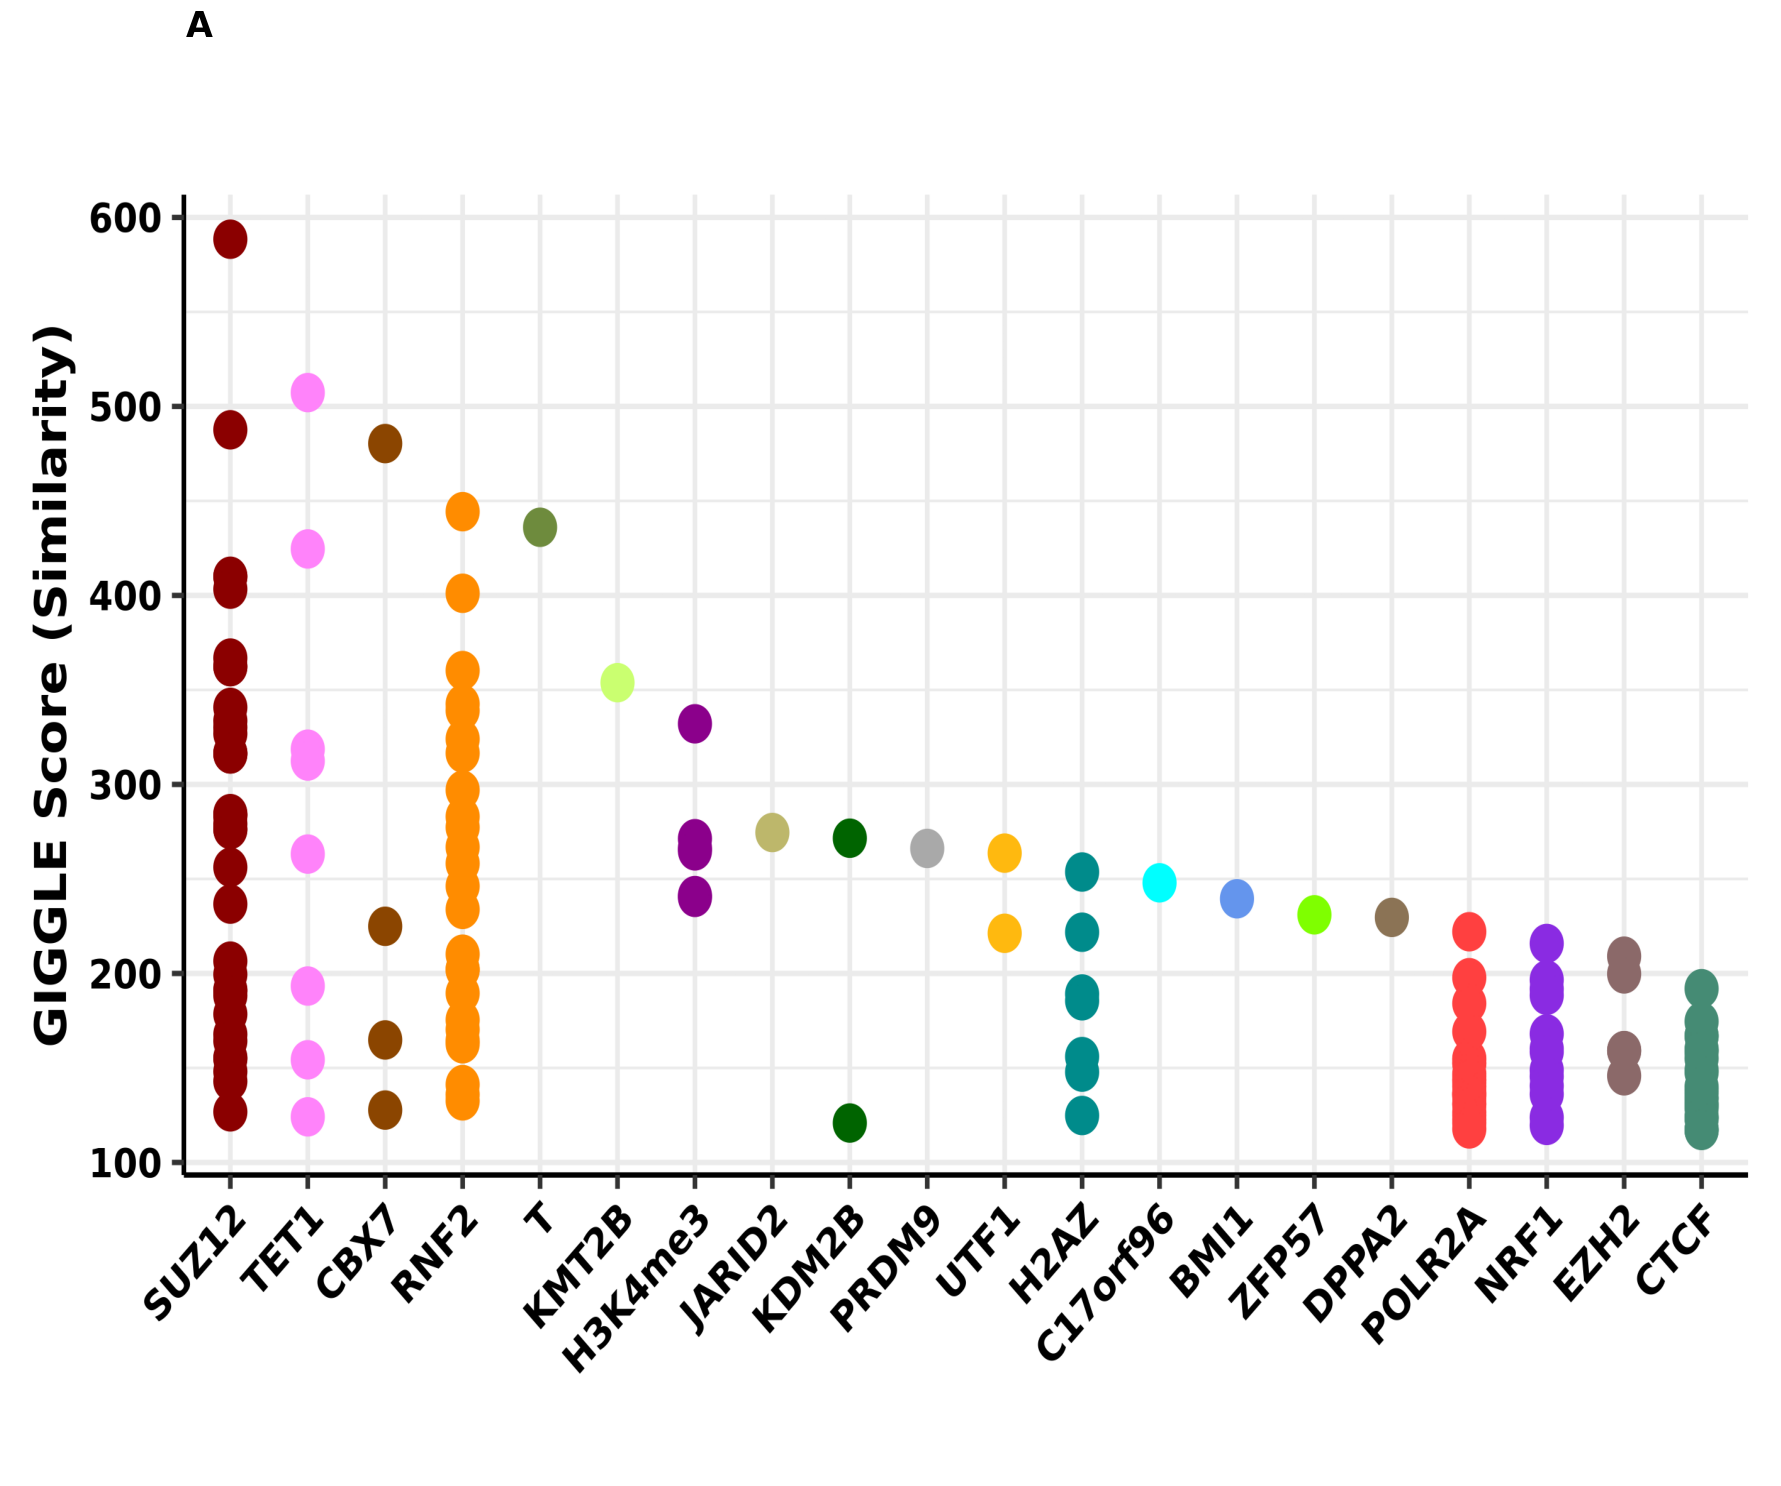

In [21]:
get_cistrome(probe_df, fig_w=5000, fig_h=1700, check_pval=False, top_10k=True)